### 1.Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Conv1D,MaxPooling1D
from keras.layers.core import Dense, Activation,Dropout ,Flatten, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint,TensorBoard, ReduceLROnPlateau,EarlyStopping
from keras.applications import Xception
from keras import regularizers
from keras import backend as K
import keras
import numpy as np
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


### 2. Initialize the seed inorder to get the same output every single time

In [2]:
seed = 120
np.random.seed(seed)

### 3. Loading the training data

In [3]:
train_path = 'D:/Software/01 Android Studio/Intent-classification/data/train/data_en.csv'
train_df = pd.read_csv(train_path, encoding = "ISO-8859-1")# Loading a csv file with headers 
train_df.head()

,sentence,name,company,job
0,aaban,1,0,0
1,aabas,1,0,0
2,aabha,1,0,0
3,aabia,1,0,0
4,aabid,1,0,0


# Plot the data frame

In [4]:
labels = ["name", "company", "job"]

def count_pandas(df):
    counts = [0] * len(labels)
    for index, data in df.iterrows():
        for label in labels:
            if data[label] > 0:
                counts[labels.index(label)] += 1
                continue
    return counts

performance = count_pandas(train_df)



[358540, 677292, 67437]


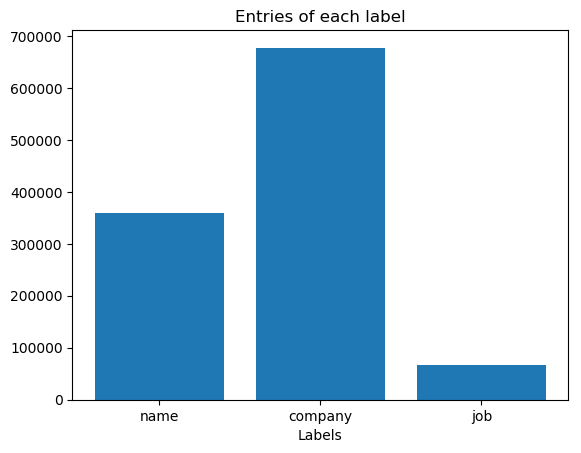

In [5]:
y_pos = np.arange(len(labels))

# Explore data
plt.rcdefaults()
fig, ax = plt.subplots()
print(performance)
ax.bar(labels, performance, align='center')
ax.set_xticks(y_pos)
ax.set_xticklabels(labels)

ax.set_xlabel('Labels')
ax.set_title('Entries of each label')

plt.show()

### 4. Shuffling the dataframe

In [8]:
train_df = shuffle(train_df)
train_df.head()

,sentence,name,company,job
345583,caitlyn harries,1,0,0
996949,marchetta bouwgroep,0,1,0
790263,servimaq,0,1,0
190748,kanable,1,0,0
674559,vitis industries,0,1,0


### 4. Now saving the dataframe column(X_train,Y_train) as a numpy array

Here,
- X_train -> Its a feature(INPUT)
- Y_tain -> Its a label(OUTPUT)

In [9]:
X_train = train_df["sentence"].fillna("fillna").values
Y_train = train_df[labels].values
print(X_train[0])
print(Y_train[0])

caitlyn harries
[1 0 0]


In [10]:
print("Shape of X_train:",X_train.shape)
print("Shape of Y_train:",Y_train.shape)

Shape of X_train: (1103269,)
Shape of Y_train: (1103269, 3)


### 7. Setting up Tokenizer class
The Tokenizer class in Keras has various methods which help to prepare text so it can be used in neural network models.

In [11]:
Tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
print(X_train[0]) # training dataset 1st sentence

caitlyn harries


In [12]:
texts = X_train
Tokenizer.fit_on_texts(texts) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
print("Tokenizer vocabulary size:",Tokenizer_vocab_size)

Tokenizer vocabulary size: 614009


### 8. Now find the length of longest sublist in X_train,X_test and set it as max Word Count

In [13]:
print(len(max(X_train, key=len)))



190


In [14]:
maxWordCount= 5
maxDictionary_size=Tokenizer_vocab_size

### 9. Now setting up data for validation and training:

In [15]:
num_test_samples = 220654 # Test samples for validation


# Phase 1: Setting up data for training
X_train = X_train[num_test_samples:] # num_test_samples samples to n ----> Sentence (Input)
Y_train = Y_train[num_test_samples:] # num_test_samples samples to n ----> Labels (Output)

# Phase 2: Setting up data for validation
X_val = X_train[:num_test_samples] # First num_test_samples Samples --> Sentence (Input)
Y_val = Y_train[:num_test_samples] # First num_test_samples Samples --> Labels (Output)

In [16]:
print("(Input->Sentence) Length of X_train:",X_train.shape) # Input -> Input
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (882615,)
(output->Labels) Length of Y_train: (882615, 3)


###  11.  Encoding Operation--->Turn text into a numerical array(using Tokenizer.texts_to_sequences)--->Uses Tokenizer_word_index.


In [17]:
# Phase 3: Encoding Operation--->Turn text into a numerical array(using Tokenizer.texts_to_sequences)--->Uses Tokenizer_word_index.
X_train_encoded_words = Tokenizer.texts_to_sequences(X_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(X_val)

In [18]:
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labelsprint("(Input->Sentence) Length of X_train:",len(X_train_encoded_words)) # Input -> Input

(output->Labels) Length of Y_train: (882615, 3)


### 12. Padding all text to same size

In [19]:
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen=maxWordCount)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen=maxWordCount)

In [20]:
print("(Input->Sentence) Length of X_train:",X_train_encoded_padded_words.shape) # Input -> Input
print("(output->Labels) Length of Y_train:",Y_train.shape) # output -> Labels

(Input->Sentence) Length of X_train: (882615, 5)
(output->Labels) Length of Y_train: (882615, 3)


In [21]:
print(Y_train.shape)
print(Y_val.shape)

(882615, 3)
(220654, 3)


### 13. Now defining the neural network model

In [22]:
#model
model = Sequential()
model.add(Embedding(maxDictionary_size, 32, input_length=maxWordCount)) #to change words to ints
 #hidden layers
model.add(LSTM(64))
model.add(Dropout(0.6))
model.add(Dense(1200, activation='relu',W_constraint=maxnorm(1)))
model.add(Dense(500, activation='relu',W_constraint=maxnorm(1)))
 #output layer
model.add(Dense(3, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 32)             19648288  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              78000     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               600500    
_________________________________________________________________
dense_3 (Dense)      

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1200, activation="relu", kernel_constraint=<keras.con...)`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", kernel_constraint=<keras.con...)`
  


### 14. Now setting up learning rate,optimizers,batch_size, and compiling the model

In [23]:
learning_rate=0.001
epochs = 25
batch_size = 64
adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
print(X_train_encoded_padded_words.shape)
print(Y_train.shape)

print(X_val_encoded_padded_words.shape)
print(Y_val.shape)

(882615, 5)
(882615, 3)
(220654, 5)
(220654, 3)


### 15. Training the model

In [25]:
# model.fit(Train_input,Train_output,epochs,batch_size,verbose,validation_data=(val_input,val_output))
history  = model.fit(X_train_encoded_padded_words,Y_train, epochs = epochs, batch_size=batch_size, verbose=1,
                    validation_data=(X_val_encoded_padded_words, Y_val))

Instructions for updating:
Use tf.cast instead.
Train on 882615 samples, validate on 220654 samples
Epoch 1/25
882615/882615 [==============================] - 3192s 4ms/step - loss: 0.3481 - acc: 0.7973 - val_loss: 0.1659 - val_acc: 0.9618
Epoch 2/25
882615/882615 [==============================] - 3173s 4ms/step - loss: 0.0880 - acc: 0.9730 - val_loss: 0.0350 - val_acc: 0.9898
Epoch 3/25
882615/882615 [==============================] - 3173s 4ms/step - loss: 0.0390 - acc: 0.9889 - val_loss: 0.0190 - val_acc: 0.9942
Epoch 4/25
882615/882615 [==============================] - 3183s 4ms/step - loss: 0.0276 - acc: 0.9920 - val_loss: 0.0157 - val_acc: 0.9950
Epoch 5/25
882615/882615 [==============================] - 3390s 4ms/step - loss: 0.0226 - acc: 0.9932 - val_loss: 0.0130 - val_acc: 0.9956
Epoch 6/25
882615/882615 [==============================] - 3363s 4ms/step - loss: 0.0196 - acc: 0.9940 - val_loss: 0.0109 - val_acc: 0.9962
Epoch 7/25
882615/882615 [============================

### 16. Calculating the score

In [26]:
print("=============================== Score =========================================")
# Finally calucating the score.
score = model.evaluate(X_val_encoded_padded_words, Y_val, verbose=1)
print('Test accuracy:', score[1],'%')

=============================== Score =========================================
220654/220654 [==============================] - 19s 85us/step
Test accuracy: 0.9981509512630634 %


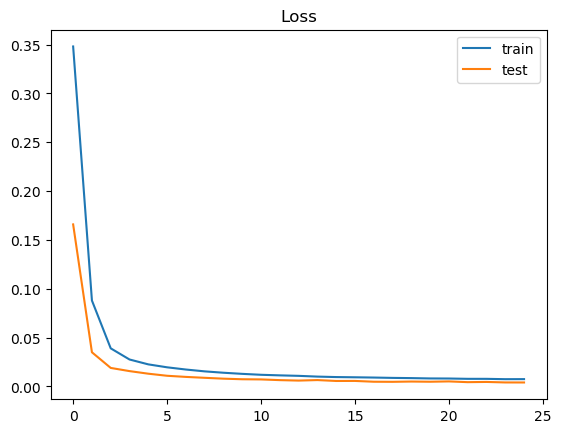

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

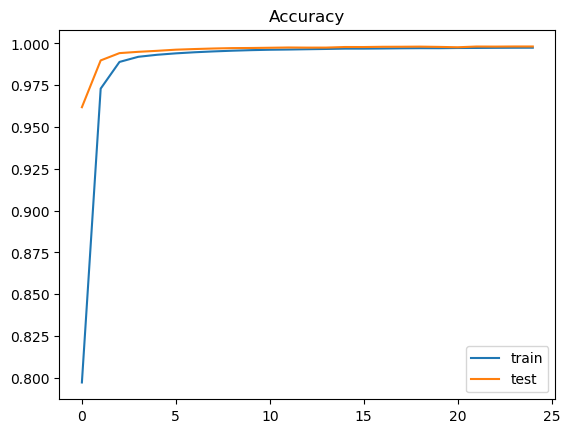

In [28]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

### 17. Predicting the text

In [29]:
phrase = "Dung Luong"
tokens = Tokenizer.texts_to_sequences([phrase])
tokens = pad_sequences(tokens, maxlen=5)
prediction = model.predict(np.array(tokens))
i,j = np.where(prediction == prediction.max()) #calculates the index of the maximum element of the array across all axis
# i->rows, j->columns
i = int(i)
j = int(j)
print(prediction)
total_possible_outcomes = ["1_name", "2_company", "3_job"]
print("Result:",total_possible_outcomes[j])


[[9.9999964e-01 3.1296062e-07 2.4055251e-13]]
Result: 1_name


### 18. Saving your model to json and weights as HDF5 format

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("D:/Software/01 Android Studio/Intent-classification/data/train/model3.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("D:/Software/01 Android Studio/Intent-classification/data/train/model3.h5")
print("Saved model to disk")

Saved model to disk


### 19. Storing Tokenizer for storing

In [31]:
# saving
with open('D:/Software/01 Android Studio/Intent-classification/data/train/tokenizer3.pickle', 'wb') as handle:
    pickle.dump(Tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)